In [1]:
pip install scikit-fuzzy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gym

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install gym[classic_control]

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import skfuzzy as fuzz
import gym
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl

In [5]:
# Define the input variables
x_position = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), 'x_position')
y_position = ctrl.Antecedent(np.arange(-1, 1.1, 0.1), 'y_position')
angular_velocity = ctrl.Antecedent(np.arange(-8, 8.1, 0.1), 'angular_velocity')

# Define the output variable
torque = ctrl.Consequent(np.arange(-2, 2.2, 0.2), 'torque')

In [6]:
# Define the fuzzy sets for input variables
y_position['positive'] = fuzz.trimf(y_position.universe, [0, 0.5, 1])
y_position['negative'] = fuzz.trimf(y_position.universe, [-1, -0.5, 0])

x_position['zero_left'] = fuzz.trimf(x_position.universe, [0, 0.125, 0.25])
x_position['left'] = fuzz.trimf(x_position.universe, [0.25, 0.625, 1])
x_position['right'] = fuzz.trimf(x_position.universe, [-1, -0.625, -0.25])
x_position['zero_right'] = fuzz.trimf(x_position.universe, [-0.25, -0.125, 0])

angular_velocity['slow_cc'] = fuzz.trimf(angular_velocity.universe, [0, 1, 2])
angular_velocity['medium_cc'] = fuzz.trimf(angular_velocity.universe, [2, 3.5, 5])
angular_velocity['fast_cc'] = fuzz.trimf(angular_velocity.universe, [5, 6.5, 8])

angular_velocity['fast_c'] = fuzz.trimf(angular_velocity.universe, [-8, -6.5, -5])
angular_velocity['medium_c'] = fuzz.trimf(angular_velocity.universe, [-5, -3.5, -2])
angular_velocity['slow_c'] = fuzz.trimf(angular_velocity.universe, [-2, -1, 0])

angular_velocity['negative'] = fuzz.trimf(angular_velocity.universe, [-8, -4, 0])
angular_velocity['positive'] = fuzz.trimf(angular_velocity.universe, [0, 4, 8])

# Define the fuzzy sets for the output variable
torque['slow_cc'] = fuzz.trimf(torque.universe, [0, 0.375, 0.75])
torque['medium_cc'] = fuzz.trimf(torque.universe, [0.75, 1.125, 1.5])
torque['fast_cc'] = fuzz.trimf(torque.universe, [1.5, 1.75, 2])

torque['fast_c'] = fuzz.trimf(torque.universe, [-2, -1.75, -1.5])
torque['medium_c'] = fuzz.trimf(torque.universe, [-1.5, -1.125, -0.75])
torque['slow_c'] = fuzz.trimf(torque.universe, [-0.75, -0.375, 0])

torque['same'] = fuzz.trimf(torque.universe, [-0.1, 0, 0.1])

/home/reyhan/anaconda3/lib/python3.9/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


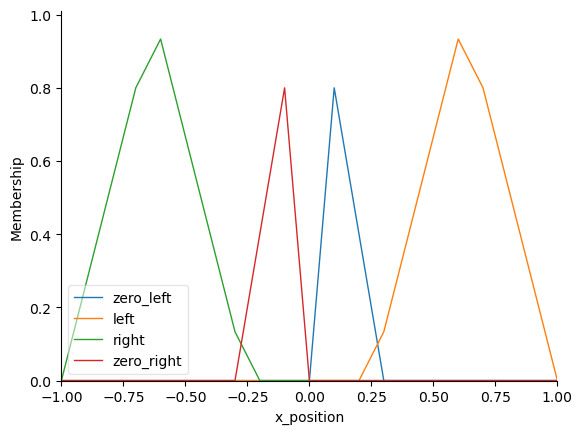

In [7]:
x_position.view()

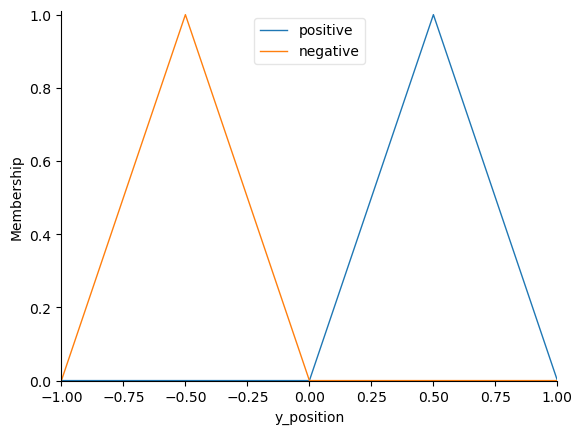

In [8]:
y_position.view()

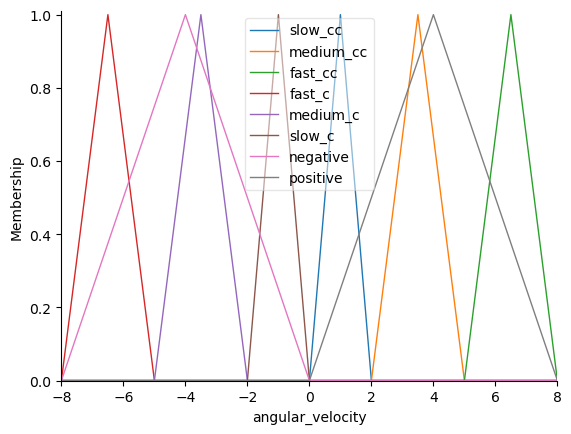

In [9]:
angular_velocity.view()

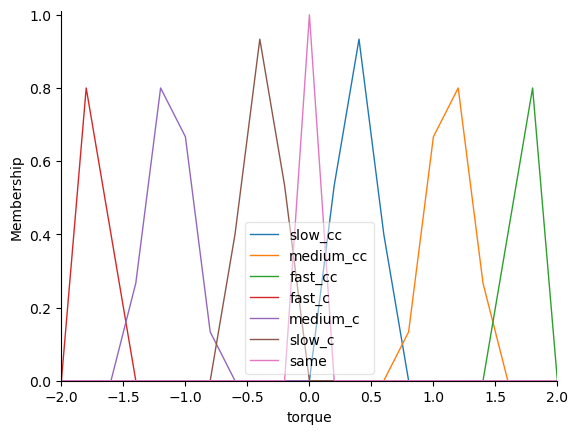

In [10]:
torque.view()

In [11]:
# Define the rules for the fuzzy logic controller

# Quarter 1
rule1 = ctrl.Rule(x_position['zero_right'] & y_position['positive'] & angular_velocity['slow_c'], torque['medium_cc'])
rule2 = ctrl.Rule(x_position['zero_right'] & y_position['positive'] & (angular_velocity['medium_c'] | angular_velocity['fast_c']), torque['fast_cc'])
rule3 = ctrl.Rule(x_position['zero_right'] & y_position['positive'] & (angular_velocity['slow_cc'] | angular_velocity['medium_cc'] |angular_velocity['fast_cc']), torque['medium_c'])
rule4 = ctrl.Rule(x_position['zero_right'] & y_position['positive'] & angular_velocity['positive'], torque['same'])
rule5 = ctrl.Rule(x_position['right'] & y_position['positive'] & (angular_velocity['negative'] | angular_velocity['positive']), torque['same'])

# Quarter 2
rule6 = ctrl.Rule(x_position['zero_left'] & y_position['positive'] & (angular_velocity['slow_cc'] | angular_velocity['medium_cc'] |angular_velocity['fast_cc']), torque['fast_c'])
rule7 = ctrl.Rule(x_position['left'] & y_position['positive'] & angular_velocity['positive'], torque['fast_c'])
rule8 = ctrl.Rule((x_position['zero_left'] | x_position['left']) & y_position['positive'] & angular_velocity['negative'], torque['same'])

# Quarter 3
rule9 = ctrl.Rule((x_position['zero_left'] | x_position['left']) & y_position['negative'] & (angular_velocity['slow_c'] | angular_velocity['medium_c']), torque['fast_c'])
rule10 = ctrl.Rule((x_position['zero_left'] | x_position['left']) & y_position['negative'] & (angular_velocity['fast_c'] | angular_velocity['positive']), torque['same'])

# Quarter 4
rule11 = ctrl.Rule((x_position['zero_right'] | x_position['right']) & y_position['negative'] & (angular_velocity['slow_cc'] | angular_velocity['medium_cc'] | angular_velocity['fast_cc']), torque['fast_cc'])
rule12 = ctrl.Rule((x_position['zero_right'] | x_position['right']) & y_position['negative'] & (angular_velocity['fast_c'] | angular_velocity['negative']) , torque['same'])

In [12]:
# Create the fuzzy control system and simulation
pendulum_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, 
                                    rule6, rule7, rule8, rule9, rule10, rule11, rule12])
pendulum_sim = ctrl.ControlSystemSimulation(pendulum_ctrl)

In [13]:
env = gym.make("Pendulum-v1",g=9.81, render_mode="human")

rewards =[]

# Reset the environment
observation, _ = env.reset()

# Main loop
for step in range(500):
    # Set the inputs
    print("State: ", observation)
    pendulum_sim.input['y_position'] = observation[0]
    pendulum_sim.input['x_position'] = observation[1]
    pendulum_sim.input['angular_velocity'] = observation[2]

    # Compute the fuzzy output
    pendulum_sim.compute()

    # Get the torque decision from the fuzzy system
    decision = pendulum_sim.output['torque']
    print("decision : ", decision )

    # Apply the torque to the pendulum
    observation, reward, terminated, noneed1, noneed2 = env.step([decision])
    rewards.append(reward)

    if observation[0] > 0.99 and abs(observation[2]) < 1.5:
        terminated = True

    # Render the environment
    env.render()

    if terminated:
        print(f'You Win in {step} iteration!')
        break

env.close()

State:  [-0.98679024 -0.1620031  -0.86654437]
decision :  -4.797157532637013e-16
State:  [-0.9935733  -0.11319022 -0.98573816]
decision :  -5.375711135767708e-16
State:  [-0.9982016  -0.05994647 -1.0690179 ]
decision :  -5.513931851723112e-16
State:  [-0.99999064 -0.00432624 -1.1131234 ]
decision :  9.845111738753531e-14
State:  [-0.99867475  0.05146632 -1.1163064 ]
decision :  -1.7001655645835776
State:  [-0.993027    0.11788754 -1.333465  ]
decision :  -1.7008690738009147
State:  [-0.9813842  0.1920546 -1.5018595]
decision :  -1.702308493432051
State:  [-0.9626826   0.27063286 -1.6159017 ]
decision :  -1.7045885949168134
State:  [-0.9367137   0.35009634 -1.6724719 ]
decision :  -1.7076842665286474
State:  [-0.90422875  0.4270484  -1.671041  ]
decision :  -1.711428724723445
State:  [-0.86687165  0.49853134 -1.6135545 ]
decision :  -1.715533686354028
State:  [-0.826965   0.5622535 -1.5040902]
decision :  -1.719639559436063
State:  [-0.7872091   0.61668617 -1.348358  ]
decision :  -1.72

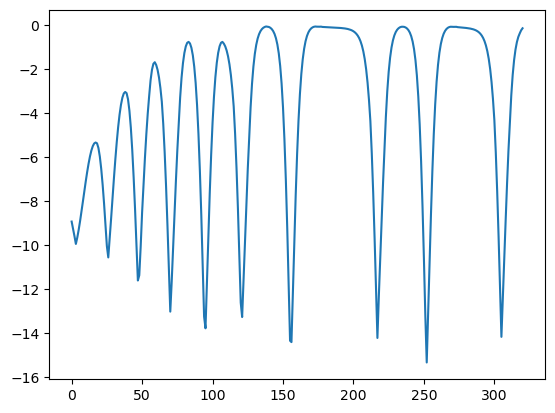

In [15]:
plt.plot(rewards)